<div style="text-align: center;">
    <h3>Applied Data Science Project</h3>
    <h2><b>Patient Preference Studies Classification System</b><h2>
    <h1><b>Design & Test BERT-Base Models</b></h1>
    <h5>Francesco Giuseppe Gillio</h5>
    <h5>César Augusto Seminario Yrigoyen</h5>
</div>

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/it/4/47/Logo_PoliTo_dal_2021_blu.png" width="250">
</div>

https://github.com/adsp-polito/2024-P8-PPS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *Drive* **Setup**

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Patient Preference Studies Binary Classifier
root = 'PPS-BC'

In [4]:
path = os.path.join('/content/drive/MyDrive', root)
if not os.path.exists(path):
    os.makedirs(path)

In [5]:
paths = {
    'input-data': f'{root}/input-data',
    'bert-embeddings': f'{root}/bert-embeddings',
    'notebook-results': f'{root}/notebook-results',
}

In [6]:
for key, value in paths.items():
    path = os.path.join('/content/drive/MyDrive', value)
    if not os.path.exists(path):
        os.makedirs(path)

**Notebook Directory Structure**
```
/PPS-BC
├── /bert-embeddings
│   └── ...
└── /notebook-results
    └── /bert-base-models
        └── ...
```

# *BERT-Base* **Models**
**T4 GPU**

**Requirements**

In [7]:
import os
import gc
import torch

from typing import List

In [8]:
from transformers import AutoTokenizer, AutoModel
from transformers.utils.logging import disable_progress_bar

In [9]:
torch.manual_seed(42)
disable_progress_bar()

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
output = os.path.join(f"/content/drive/MyDrive/{paths['notebook-results']}", 'bert-base-models')
if not os.path.exists(output):
    os.makedirs(output)

In [12]:
with open(os.path.join(output, 'logs.txt'), 'w') as file:
    pass

**BERT-Base Models**

In [13]:
models = [

    # BERT-base
    'bert-base-uncased',

    # Sentence-Transformer (BERTopic)
    'sentence-transformers/all-mpnet-base-v2',

    # PubMedBERT (BERT for PubMed Text)
    'NeuML/pubmedbert-base-embeddings',
    'pritamdeka/S-PubMedBert-MS-MARCO',
    'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract',

    # BioLinkBERT (LinkBERT for Biomedical Text)
    'michiyasunaga/BioLinkBERT-base',

    # SapBERT (Self-Alignment BERT for Biomedical Text)
    'cambridgeltl/SapBERT-from-PubMedBERT-fulltext',

    # SciBERT (BERT for Scientific Text)
    'allenai/scibert_scivocab_uncased',

    # BioBERT (BERT for Biomedical Text)
    'dmis-lab/biobert-base-cased-v1.2',

    # ClinicalBERT (BioBERT for Clinical Text)
    'emilyalsentzer/Bio_ClinicalBERT'

]

* Model Check

In [14]:
def control(
    models: List[str],
    device: str,
    output: str
) -> List[str]:
    """
    control function to validate models by pooling tests and sentence similarity tasks

    args:
        models (List[str]): list of input bert-base models
        device (str): device ('cuda' or 'cpu')
        output (str): path to output folder to store logs

    returns:
        List[str]: list of valid models
    """
    texts = ['sample text for validation']
    compatible = list()
    for base in models:
        log = f'{base} model check...'
        with open(os.path.join(output, 'logs.txt'), 'a') as file:
            file.write(log + '\n')
        print(log)
        try:
            tokenizer = AutoTokenizer.from_pretrained(base)
            model = AutoModel.from_pretrained(base).to(device)
            inputs = tokenizer(
                texts,
                padding=True,
                truncation=True,
                return_tensors='pt',
                max_length=512
            )
            inputs = {
                key: value.to(device)
                for key, value in inputs.items()
            }
            if 'attention_mask' not in inputs:
                log = f'{base} tokenizer: incompatible with attention mask\n'
                with open(os.path.join(output, 'logs.txt'), 'a') as file:
                    file.write(log + '\n')
                print(log)
                continue
            with torch.no_grad():
                outputs = model(**inputs)
            pooler_output = hasattr(
                outputs, 'pooler_output'
            ) and outputs.pooler_output is not None
            last_hidden_state = hasattr(
                outputs, 'last_hidden_state'
            ) and outputs.last_hidden_state is not None
            if not (pooler_output or last_hidden_state):
                log = f'{base} model output: incompatible with pooling methods\n'
                with open(os.path.join(output, 'logs.txt'), 'a') as file:
                    file.write(log + '\n')
                print(log)
                continue
            log = f'status: pass\n'
            with open(os.path.join(output, 'logs.txt'), 'a') as file:
                file.write(log + '\n')
            print(log)
            compatible.append(base)
            del model
            gc.collect()
            torch.cuda.empty_cache()
        except (OSError, ValueError) as e:
            log = f'status: out\n'
            with open(os.path.join(output, 'logs.txt'), 'a') as file:
                file.write(log + '\n')
            print(log)
    return compatible

In [15]:
models = control(models, device, output)

bert-base-uncased model check...
status: pass

sentence-transformers/all-mpnet-base-v2 model check...
status: pass

NeuML/pubmedbert-base-embeddings model check...
status: pass

pritamdeka/S-PubMedBert-MS-MARCO model check...
status: pass

microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract model check...
status: pass

michiyasunaga/BioLinkBERT-base model check...
status: pass

cambridgeltl/SapBERT-from-PubMedBERT-fulltext model check...
status: pass

allenai/scibert_scivocab_uncased model check...
status: pass

dmis-lab/biobert-base-cased-v1.2 model check...
status: pass

emilyalsentzer/Bio_ClinicalBERT model check...
status: pass



# **Design** *BERT-Base Embeddings*
**T4 GPU**

**Requirements**

In [16]:
import os
import gc
import sys
import time
import torch
import numpy as np
import pandas as pd

from typing import List, Dict, Union, Tuple

In [17]:
from transformers import AutoTokenizer, AutoModel
from transformers.utils.logging import disable_progress_bar

In [18]:
np.random.seed(42)
torch.manual_seed(42)
disable_progress_bar()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
input = f"/content/drive/MyDrive/{paths['input-data']}"
output = f"/content/drive/MyDrive/{paths['bert-embeddings']}"

In [21]:
with open(os.path.join(output, 'logs.txt'), 'w') as file:
    pass

**BERT-Base Sentence Embeddings Function**

With **AutoModel**, **AutoConfig** and **AutoTokenizer** instances the code returns a class of the relevant architecture.

For example:
```
model = AutoModel.from_pretrained('bert-base-cased')  # returns an instance of BertModel
```

```
with torch.no_grad():
    outputs = model(**inputs)  # runs the input through the BERT model

# sequence of hidden-states at the output of the last layer of the model
states = outputs.last_hidden_state

print(torch.equal(outputs[0], outputs.last_hidden_state))  # return True

# last layer hidden-state of the first token of the sequence (classification token)
CLS = outputs.last_hidden_state[:, 0, :]

# last layer hidden-state of the first token of the sequence (classification token)
# after further processing by a Linear layer and a Tanh activation function
CLS = outputs.pooler_output
```


* **outputs.last_hidden_state**

sequence of hidden-states at the output of the last layer of the model

shape: torch.FloatTensor of shape (batch size, sequence length, hidden size)

* **outputs.last_hidden_state[:, 0, :]**

raw hidden state of the [CLS] token of the last layer of the model

shape: torch.FloatTensor of shape (batch size, hidden size)

* **outputs.pooler_output**

last layer hidden-state of the first token of the sequence (classification token) after further processing by a Linear layer and a Tanh activation function. The Linear layer weights comes from a training process by next sentence prediction (classification) objective over pre-training.

shape: torch.FloatTensor: of shape (batch size, hidden size)

**WARNING** on **outputs.pooler_output**: this output often appears unsuitable as a summary of the semantic content of the input; hugging face suggests averaging or pooling the sequence of hidden states over the entire input sequence.

In [22]:
def encode(
    titles: List[str],
    abstracts: List[str],
    tokenizer: AutoTokenizer,
    model: AutoModel,
    device: str,
    pooling: bool,
    case: int
) -> np.ndarray:
    """
    encode titles and abstracts via pre-trained input bert-base model

    args:
        titles (List[str]): batch of document titles
        abstracts (List[str]): batch of document abstracts
        tokenizer (AutoTokenizer): pre-trained bert-base tokenizer
        model (AutoModel): pre-trained bert-base model
        device (str): device ('cuda' or 'cpu')
        pooling (bool): output type identifier
            True: mean-pooling (outputs.last_hidden_state)
            False: outputs.pooler_output
        case (int): input type identifier

    returns:
        numpy.ndarray: batch of sentence embeddings
    """

    def meanpooling(
        output: Tuple[torch.Tensor, ...],
        mask: torch.Tensor
    ) -> torch.Tensor:
        """
        perform mean pooling on token embeddings

        args:
            output (Tuple[torch.Tensor, ...]): model output
            mask (torch.Tensor): attention mask with valid token positions

        returns:
            torch.Tensor: sentence embeddings by mean pooling over token embeddings
        """
        embeddings = output[0]
        mask = mask.unsqueeze(-1).expand(embeddings.size()).float()
        return torch.sum(embeddings * mask, 1) / torch.clamp(mask.sum(1), min=1e-9)

    def tokenize(
        texts: List[str],
        tokenizer: AutoTokenizer
    ) -> dict:
        """
        tokenize a batch of texts

        args:
            texts (List[str]): texts to tokenize
            tokenizer (AutoTokenizer): pre-trained bert-base tokenizer

        returns:
            dict: tokens as tensors
        """
        inputs = tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=512
        )
        inputs = {
            key: value.to(device)
            for key, value in inputs.items()
        }
        return inputs

    def get(
        texts: List[str],
        model: AutoModel,
        tokenizer: AutoTokenizer,
        pooling: bool
    ) -> torch.Tensor:
        """
        get embeddings for a batch of texts

        args:
            texts (List[str]): texts to encode
            model (AutoModel): pre-trained bert-base model
            tokenizer (AutoTokenizer): pre-trained bert-base tokenizer
            pooling (bool): output type identifier

        returns:
            torch.Tensor: embeddings as tensors
        """
        inputs = tokenize(texts, tokenizer)
        with torch.no_grad():
            output = model(**inputs)
        embeddings = output.pooler_output if not pooling else meanpooling(
            output,
            inputs['attention_mask']
        )
        return embeddings

    # case 1 (title-text): title embedding (no abstract)
    if case == 1:
        embeddings = get(titles, model, tokenizer, pooling).cpu().numpy()
        return embeddings
    # case 2 (abstract-text): abstract embedding (no title)
    if case == 2:
        embeddings = get(abstracts, model, tokenizer, pooling).cpu().numpy()
        return embeddings
    # case 3 (text-concatenation): concatenate title text and abstract text into a single embedding
    if case == 3:
        texts = [(title + ". " + abstract) for title, abstract in zip(titles, abstracts)]
        embeddings = get(texts, model, tokenizer, pooling).cpu().numpy()
        return embeddings
    # case 4 (vector-sum): vector sum of title and abstract embeddings
    if case == 4:
        titles = get(titles, model, tokenizer, pooling)
        abstracts = get(abstracts, model, tokenizer, pooling)
        embeddings = titles + abstracts
        return embeddings.cpu().numpy()
    # case 5 (vector-concatenation): vector concatenation of title and abstract embeddings
    if case == 5:
        titles = get(titles, model, tokenizer, pooling)
        abstracts = get(abstracts, model, tokenizer, pooling)
        embeddings = torch.cat((titles, abstracts), dim=-1)
        return embeddings.cpu().numpy()
    # case 6 (vector-average): vector average of title and abstract embeddings (50% title, 50% abstract)
    if case == 6:
        titles = get(titles, model, tokenizer, pooling)
        abstracts = get(abstracts, model, tokenizer, pooling)
        embeddings = 0.5 * titles + 0.5 * abstracts
        return embeddings.cpu().numpy()
    # case 7 (vector-weighted-average-4060): vector weighted average of title and abstract embeddings (40% title, 60% abstract)
    if case == 7:
        titles = get(titles, model, tokenizer, pooling)
        abstracts = get(abstracts, model, tokenizer, pooling)
        embeddings = 0.4 * titles + 0.6 * abstracts
        return embeddings.cpu().numpy()
    # case 8 (vector-weighted-average-3070): vector weighted average of title and abstract embeddings (30% title, 70% abstract)
    if case == 8:
        titles = get(titles, model, tokenizer, pooling)
        abstracts = get(abstracts, model, tokenizer, pooling)
        embeddings = 0.3 * titles + 0.7 * abstracts
        return embeddings.cpu().numpy()
    # case 9 (vector-weighted-average-2080): vector weighted average of title and abstract embeddings (20% title, 80% abstract)
    if case == 9:
        titles = get(titles, model, tokenizer, pooling)
        abstracts = get(abstracts, model, tokenizer, pooling)
        embeddings = 0.2 * titles + 0.8 * abstracts
        return embeddings.cpu().numpy()
    # case 10 (vector-weighted-average-1090): vector weighted average of title and abstract embeddings (10% title, 90% abstract)
    if case == 10:
        titles = get(titles, model, tokenizer, pooling)
        abstracts = get(abstracts, model, tokenizer, pooling)
        embeddings = 0.1 * titles + 0.9 * abstracts
        return embeddings.cpu().numpy()

**Iteration Function** (Data & Models for Embedding)

In [23]:
def process(
    input: str,
    output: str,
    models: List[str],
    cases: Dict[Union[str, int], str],
    types: Dict[str, bool],
    device: str,
    size: int
) -> None:
    """
    process models, encode data, archive outputs

    args:
        input (str): path to the input folder with data and splits
        output (str): path to the output folder to store logs & embeddings
        models (List[str]): bert-base models
        cases (Dict[Union[str, int], str]): input type identifiers
        types (Dict[str, bool]): output type identifiers
        device (str): device ('cuda' or 'cpu')
        size (int): batch size to process at once
    """

    def remove(model):
        del model
        gc.collect()
        torch.cuda.empty_cache()

    for base in models:
        desc = base.split('/')[-1] if '/' in base else base
        desc = desc.replace('_', '-') if '_' in desc else desc
        root = os.path.join(output, desc)
        os.makedirs(root, exist_ok=True)
        # pre-trained bert-base model from HuggingFace Hub
        tokenizer = AutoTokenizer.from_pretrained(base)
        model = AutoModel.from_pretrained(base)
        model = model.to(device)
        print(f"processing {desc}...")
        combinations, progress = len(cases) * len(types), 0
        for case, value in cases.items():
            for key, pooling in types.items():
                progress += 1
                percentage = (progress / combinations) * 100
                sys.stdout.write(f"\rencoding data... {percentage:.2f}%")
                sys.stdout.flush()
                path = os.path.join(input, 'clean-articles-2023.csv')
                dataset = pd.read_csv(path)
                rows, total = len(dataset), 0
                embedding = f'{desc}-{value}-{key}'
                log = f'{desc}-{value}-{key} on device...'
                with open(os.path.join(output, 'logs.txt'), 'a') as file:
                    file.write(log + '\n')
                # process data in batches
                embeddings = list()
                for x in range(0, rows, size):
                    y = x + size
                    titles = dataset['title'][x:y].tolist()
                    abstracts = dataset['abstract'][x:y].tolist()
                    start = time.time()
                    batch = encode(
                        titles,
                        abstracts,
                        tokenizer,
                        model,
                        device,
                        pooling,
                        case
                    )
                    end = time.time()
                    embeddings.append(batch)
                    total += end - start
                dataset[embedding] = [
                    embedding for batch in embeddings
                    for embedding in batch
                ]
                average = total / rows
                log = f'status: pass'
                with open(os.path.join(output, 'logs.txt'), 'a') as file:
                    file.write(log + '\n')
                log = f'time: {average:.3f}\n'
                with open(os.path.join(output, 'logs.txt'), 'a') as file:
                    file.write(log + '\n')
                path = os.path.join(root, f'{value}-{key}.pkl')
                dataset.to_pickle(path)
        remove(model)
        print()

**T&A Links**

In [24]:
# input type identifiers
cases = {
    1: 'title-text',
    2: 'abstract-text',
    3: 'text-concatenation',
    4: 'vector-sum',
    5: 'vector-concatenation',
    6: 'vector-average',
    7: 'vector-weighted-average-4060',
    8: 'vector-weighted-average-3070',
    9: 'vector-weighted-average-2080',
    10: 'vector-weighted-average-1090'
}

# output type identifiers
types = {
    'hidden-states': True,
    'classification-token': False
}

In [25]:
process(input, output, models, cases, types, device, 256)

processing bert-base-uncased...
encoding data... 100.00%
processing all-mpnet-base-v2...
encoding data... 100.00%
processing pubmedbert-base-embeddings...
encoding data... 100.00%
processing S-PubMedBert-MS-MARCO...
encoding data... 100.00%
processing BiomedNLP-BiomedBERT-base-uncased-abstract...
encoding data... 100.00%
processing BioLinkBERT-base...
encoding data... 100.00%
processing SapBERT-from-PubMedBERT-fulltext...
encoding data... 100.00%
processing scibert-scivocab-uncased...
encoding data... 100.00%
processing biobert-base-cased-v1.2...
encoding data... 100.00%
processing Bio-ClinicalBERT...
encoding data... 100.00%


# **Test** *BERT-Base Embeddings* by *Linear Separation* via **Maximum-Margin Hyperplane**
**CPU**

**Requirements**

In [7]:
import os
import sys
import numpy as np
import pandas as pd

from typing import List, Dict, Tuple

In [8]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss
)

In [9]:
np.random.seed(42)

In [10]:
device = 'cpu'
device

'cpu'

In [11]:
input = f"/content/drive/MyDrive/{paths['input-data']}"
output = os.path.join(f"/content/drive/MyDrive/{paths['notebook-results']}", 'bert-base-models')

*BERT-Base Embeddings*

In [12]:
dir = f"/content/drive/MyDrive/{paths['bert-embeddings']}"

**Evaluation Metrics**

In [13]:
def compute(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_prob: np.ndarray
) -> Dict[str, float]:
    """
    compute classification metrics for predictions

    args:
        y_true (np.ndarray): ground truth labels for the test set
        y_pred (np.ndarray): predictions for the test set
        y_prob (np.ndarray): probabilities for the positive class

    returns:
        Dict[str, float]: a dictionary with classification metrics
    """
    metrics = {
        'F2-PPS': fbeta_score(
            y_true, y_pred, beta=2, pos_label=1
        ),  # F2-Score (Class 1)
        'F1-PPS': f1_score(
            y_true, y_pred, pos_label=1
        ),  # F1-Score (Class 1)

        'TPR': recall_score(
            y_true, y_pred, pos_label=1
        ),  # True Positive Rate (TPR)
        'FNR': 1 - recall_score(
            y_true, y_pred, pos_label=1
        ),  # False Negative Rate (FNR)
        'PPV': precision_score(
            y_true, y_pred, pos_label=1
        ),  # Positive Predictive Value (PPV)
        'FDR': 1 - precision_score(
            y_true, y_pred, pos_label=1
        ),  # False Discovery Rate (FDR)

        'AUC-PR': average_precision_score(
            y_true, y_prob
        ),  # Area Under Precision-Recall Curve (AUC-PR)
        'BA': balanced_accuracy_score(
            y_true, y_pred
        ),  # Balanced Accuracy (BA)
        'AUC-ROC': roc_auc_score(
            y_true, y_prob
        ),  # Area Under ROC Curve (AUC-ROC)

        'G-Mean': np.sqrt(
            recall_score(
                y_true, y_pred, pos_label=1
            ) *
            recall_score(
                y_true, y_pred, pos_label=0
            )
        ),  # Geometric Mean (G-Mean)
        'MCC': matthews_corrcoef(
            y_true, y_pred
        ),  # Matthews Correlation Coefficient (MCC)

        'Log-Loss': log_loss(
            y_true, y_prob
        ),  # Log-Loss
        'BS': brier_score_loss(
            y_true, y_prob
        ),  # Brier Score

        'TNR': recall_score(
            y_true, y_pred, pos_label=0
        ),  # True Negative Rate (TNR)
        'FPR': 1 - recall_score(
            y_true, y_pred, pos_label=0
        ),  # False Positive Rate (FPR)
        'NPV': precision_score(
            y_true, y_pred, pos_label=0
        ),  # Negative Predictive Value (NPV)
        'FOR': 1 - precision_score(
            y_true, y_pred, pos_label=0
        ),  # False Omission Rate (FOR)

        'Accuracy': accuracy_score(
            y_true, y_pred
        ),  # Accuracy
        'Weighted F1-Score': f1_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted F1-Score
        'Weighted Precision': precision_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted Precision
        'Weighted Recall': recall_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted Recall
        'Macro F1-Score': f1_score(
            y_true, y_pred, average='macro'
        ),  # Macro F1-Score
        'Macro Precision': precision_score(
            y_true, y_pred, average='macro'
        ),  # Macro Precision
        'Macro Recall': recall_score(
            y_true, y_pred, average='macro'
        )   # Macro Recall
    }
    return metrics

*Evaluation Metrics Sorting Criteria*

In [14]:
order = [
    'F2-PPS', # F2-Score (Class 1 - Patient Preference Studies)
    'F1-PPS', # F1-Score (Class 1 - Patient Preference Studies)
    'TPR',    # True Positive Rate
    'PPV',    # Positive Predictive Value
    'AUC-PR', # Area Under Precision-Recall Curve
    'BA',     # Balanced Accuracy
    'AUC-ROC' # Area Under ROC Curve
]

**Binary Classification**

In [15]:
def evaluate(
    dir: str,
    case: str,
    input: str,
    output: str,
    order: List[str]
) -> pd.DataFrame:
    """
    evaluate bert-base models by Linear Separation via Maximum-Margin Hyperplane

    args:
        dir (str): path to the directory with bert-base embeddings
        case (str): cross-validation case identifier (e.g. 'k-fold-2' or 'k-fold-3')
        input (str): path to the input folder with data and splits
        output (str): path to output folder to store logs
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with evaluation results
    """

    def add(
        by: str,
        to: str
    ) -> pd.DataFrame:
        """
        add an embeddings column to the input split file

        args:
            by (str): path to the .pkl file with embeddings
            to (str): path to the .csv split file
        """
        dataset = pd.read_pickle(by)
        frame = pd.read_csv(to)
        embeddings = [
            column for column in dataset.columns
            if column not in ['title', 'abstract', 'label']
        ]
        data = frame.merge(
            dataset[['title', 'abstract', 'label'] + embeddings],
            on=['title', 'abstract', 'label'],
            how='left'
        )
        return data

    def collect(
        dir: str
    ) -> List[Tuple[str, str]]:
        """
        collect train and test file pairs from the directory

        args:
            dir (str): path to the directory with train/test files

        returns:
            List[Tuple[str, str]]: list of (train file, test file) tuples
        """
        files = {'train': [], 'test': []}
        for idx, _, walk in os.walk(dir):
            for file in walk:
                if file.endswith('.csv'):
                    if 'train' in file:
                        files['train'].append(
                            os.path.join(idx, file)
                        )
                    elif 'test' in file:
                        files['test'].append(
                            os.path.join(idx, file)
                        )
        files['train'].sort()
        files['test'].sort()
        return list(zip(files['train'], files['test']))

    log = f'\n{case}\n'
    with open(os.path.join(output, 'logs.txt'), 'a') as file:
        file.write(log + '\n')
    models = [
        os.path.join(dir, branch)
        for branch in os.listdir(dir)
        if os.path.isdir(os.path.join(dir, branch))
    ]
    steps = sum(
        len([file for file in os.listdir(root) if file.endswith('.pkl')])
        for root in models
    ) * len(
        collect(
            os.path.join(input, 'cv-splits', case)
        )
    )
    progress = 0
    results = list()
    print(f"processing {case}...")
    for root in models:
        for file in os.listdir(root):
            if file.endswith('.pkl'):
                embeddings = os.path.join(root, file)
                column = [
                    column for column in pd.read_pickle(embeddings).columns
                    if column not in ['label', 'title', 'abstract']
                ][0]
                link = column.replace(os.path.basename(root) + "-", "")
                log = f'-' * 50 + '\n' + f'BERT-Base Model: {os.path.basename(root)}\nT&A Link: {link}\n' + f'-' * 50 + '\n'
                with open(os.path.join(output, 'logs.txt'), 'a') as file:
                    file.write(log + '\n')
                averages = {}
                route = os.path.join(input, 'cv-splits', case)
                for files in collect(route):
                    progress += 1
                    percentage = (progress / steps) * 100
                    sys.stdout.write(f"\revaluating bert-base models... {percentage:.2f}%")
                    sys.stdout.flush()
                    log = f'classifier execution on:\n- train file: {os.path.basename(files[0])}\n- test file: {os.path.basename(files[1])}'
                    with open(os.path.join(output, 'logs.txt'), 'a') as file:
                        file.write(log + '\n')
                    data_train = add(
                        by=embeddings,
                        to=files[0]
                    )
                    data_test = add(
                        by=embeddings,
                        to=files[1]
                    )
                    y_train = data_train['label']
                    y_test = np.array(data_test['label'].tolist())
                    # skip non-embedding columns
                    column = [
                        column for column in data_train.columns
                        if column not in ['label', 'title', 'abstract']
                    ][0]
                    if not isinstance(data_train[column].values[0], np.ndarray):
                        # debug
                        print(f'WARNING: {column} not of type np.ndarray')
                        continue
                    x_train = np.array(data_train[column].tolist())
                    x_test = np.array(data_test[column].tolist())
                    try:
                        svm = SVC(
                            kernel='linear',
                            probability=True,
                            class_weight='balanced',
                            random_state=42,
                            max_iter=1000
                        )
                        pipeline = Pipeline([
                            ('scaler', StandardScaler()),
                            ('svm', svm)
                        ])
                        # train
                        pipeline.fit(x_train, y_train)
                        # test
                        y_pred = pipeline.predict(x_test)
                        y_prob = pipeline.predict_proba(x_test)
                        metrics = compute(
                            y_true=y_test,
                            y_pred=y_pred,
                            y_prob=y_prob[:, 1]
                        )
                        for metric in ['F2-PPS', 'F1-PPS', 'TPR', 'PPV']:
                            log = f"{metric}: {metrics[metric]}"
                            with open(os.path.join(output, 'logs.txt'), 'a') as file:
                                file.write(log + '\n')
                    except Exception as e:
                        # debug
                        print(f'ERROR for {column}: {e}')
                        continue
                    if column not in averages:
                        averages[column] = {
                            key: [] for key in metrics
                        }
                    for key, value in metrics.items():
                        averages[column][key].append(value)
                for column, scores in averages.items():
                    link = column.replace(os.path.basename(root) + "-", "")
                    mean = {
                        key: np.mean(values)
                        for key, values in scores.items()
                    }
                    results.append({
                        'BERT-Base Model': os.path.basename(root),
                        'T&A Link': link,
                        **mean
                    })
                    for idx, metric in enumerate(['F2-PPS', 'F1-PPS', 'TPR', 'PPV']):
                        log = ('\n' if idx == 0 else '') + metric + ': ' + str(mean[metric])
                        with open(os.path.join(output, 'logs.txt'), 'a') as file:
                            file.write(log + '\n')
    print()
    data = pd.DataFrame(results)
    data = data.sort_values(
        by=order,
        ascending=[False] * len(order)
    )
    return data

*Fibonacci Sequence:* **[2, 3, 5, 8, 13, 21]**

Splits: **[2 + 3 + 21]** & **[5 + 8 + 13]**

*Split into 2 blocks of 26 iterations for* **MxN** *configurations, with* **M = 10** *BERT-base models and* **N = 20** *cases per model*

*Computational effort per split:* **MxNx26 = 10x20x26=5.200** *iterations on* **1.215** *data points each*

In [16]:
for seed in [2, 3, 21]:
    results = evaluate(
        dir = dir,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        order = order
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-2...
evaluating bert-base models... 100.00%
processing k-fold-3...
evaluating bert-base models... 100.00%
processing k-fold-21...
evaluating bert-base models... 100.00%


In [17]:
for seed in [5, 8, 13]:
    results = evaluate(
        dir = dir,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        order = order
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-5...
evaluating bert-base models... 100.00%
processing k-fold-8...
evaluating bert-base models... 100.00%
processing k-fold-13...
evaluating bert-base models... 100.00%


# *Statistical* **Data Analysis**
**CPU**

**Requirements**

In [18]:
import os
import glob
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Dict

In [19]:
np.random.seed(42)

In [20]:
device = 'cpu'
device

'cpu'

In [21]:
output = os.path.join(f"/content/drive/MyDrive/{paths['notebook-results']}", 'bert-base-models')

*Evaluation Metrics Sorting Criteria*

In [22]:
order = [
    'F2-PPS', # F2-Score (Class 1 - Patient Preference Studies)
    'F1-PPS', # F1-Score (Class 1 - Patient Preference Studies)
    'TPR',    # True Positive Rate
    'PPV',    # Positive Predictive Value
    'AUC-PR', # Area Under Precision-Recall Curve
    'BA',     # Balanced Accuracy
    'AUC-ROC' # Area Under ROC Curve
]

In [23]:
def combine(
    dir: str,
    main: List[str],
    order: List[str]
) -> pd.DataFrame:
    """
    combine multiple .csv files into a single DataFrame

    args:
        dir (str): path to the folder with .csv files
        main (List[str]): main group-by columns
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with scores
    """
    files = glob.glob(os.path.join(dir, "*.csv"))
    data = list()
    for file in files:
        frame = pd.read_csv(file)
        data.append(frame)
    concat = pd.concat(data)
    data = (
        concat.groupby(main)
        .agg(
            ['mean', 'std']
        )
        .reset_index()
    )
    data.columns = [
        '-'.join(column).strip('-') for column in data.columns
        if column not in main
    ]
    for column in data.columns:
        if column.endswith('-mean'):
            base = column.rsplit('-', 1)[0]
            deviation = f'{base}-std'
            if deviation in data.columns:
                # compute confidence interval
                N = len(concat.groupby(main))
                sem = data[deviation] / np.sqrt(N)
                deg = N - 1
                # 99% confidence level
                critical = stats.t.ppf(0.995, deg)
                lower = data[column] - critical * sem
                upper = data[column] + critical * sem
                data[f'{base}-ci'] = (
                    data[column].round(3).astype(str) + " ± " +
                    ((upper - lower) / 2).round(3).astype(str)
                )
    data = data.sort_values(
        by=[f"{metric}-mean" for metric in order],
        ascending=[False] * len(order)
    )
    columns = [
        column for column in data.columns
        if column.endswith('-ci')
    ]
    data = data[main + columns]
    data.columns = [
        column.replace('-ci', '') for column in data.columns
    ]
    return data

In [24]:
def get(
    data: pd.DataFrame,
    case: str,
    order: List[str]
) -> pd.DataFrame:
    """
    get a dataframe by group-by on input column

    args:
        data (pd.DataFrame): DataFrame with evaluation results
        case (str): group-by column to plot (e.g., 'BERT-Base Model')
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with scores
    """
    data = data[[case] + order].copy()
    for metric in order:
        data[metric] = data[metric].str.extract(r'(\d+\.\d+)').astype(float)
    res = (
        data.groupby(case)
        .agg(
            ['mean', 'std']
        )
        .reset_index()
    )
    res.columns = [
        '-'.join(column).strip('-') for column in res.columns
        if column not in [case]
    ]
    for column in res.columns:
        if column.endswith('-mean'):
            base = column.rsplit('-', 1)[0]
            deviation = f'{base}-std'
            if deviation in res.columns:
                # compute confidence interval
                N = len(data.groupby([case]))
                sem = res[deviation] / np.sqrt(N)
                deg = N - 1
                # 99% confidence level
                critical = stats.t.ppf(0.995, deg)
                lower = res[column] - critical * sem
                upper = res[column] + critical * sem
                res[f'{base}-ci'] = (
                    res[column].round(3).astype(str) + " ± " +
                    ((upper - lower) / 2).round(3).astype(str)
                )
    res = res.sort_values(
        by=[f"{metric}-mean" for metric in order],
        ascending=[False] * len(order)
    )
    columns = [
        column for column in res.columns
        if column.endswith('-ci')
    ]
    res = res[[case] + columns]
    res.columns = [
        column.replace('-ci', '') for column in res.columns
    ]
    return res

In [25]:
def plot(
    data: pd.DataFrame,
    column: str,
    output: str,
    order: List[str]
) -> None:
    """
    plot performance metrics with confidence intervals

    args:
        data (pd.DataFrame): DataFrame with evaluation results
        column (str): group-by column to plot (e.g., 'BERT-Base Model')
        output (str): path to output folder to store plot
        order (List[str]): evaluation metrics sorting criteria
    """
    chart = list()
    for metric in order:
        if metric in data.columns:
            for _, row in data.iterrows():
                ci = row[metric].split(' ± ')
                mean = float(ci[0])
                error = float(ci[1])
                chart.append({
                    column: row[column],
                    'Metric': metric,
                    'Mean': mean,
                    'Error': error
                })
    chart = pd.DataFrame(chart)
    chart[column] = chart[column].astype(str)
    plt.figure(figsize=(16, 9))
    position = -0.75
    ax = sns.barplot(
        chart,
        x=column,
        y='Mean',
        hue='Metric',
        ci=None,
        palette='crest'
    )
    for bar, (_, row) in zip(ax.patches, chart.iterrows()):
        center = bar.get_x() + bar.get_width() / 2
        lower = row['Mean'] - row['Error']
        upper = row['Mean'] + row['Error']
        plt.errorbar(
            x=center,
            y=row['Mean'],
            yerr=row['Error'],
            fmt='none',
            color='black',
            linestyle='-',
            linewidth=0.5
        )
    for idx, metric in enumerate(chart['Metric'].unique()):
        columns = chart[chart['Metric'] == metric]
        row = columns.loc[columns['Mean'].idxmax()]
        value = row['Mean']
        center = (
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_x() +
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_width() / 2
        )
        if metric == 'F2-PPS':
            ax.plot(
                [center, position],
                [value, value],
                color='black',
                linestyle='--',
                linewidth=0.5
            )
            ax.text(
                x=position,
                y=value,
                s=f'{value:.3f}',
                ha='right',
                va='center',
                fontsize=10
            )
    plt.title(
        f'{column} Performance Distributions',
        fontsize=15
    )
    plt.xlabel(
        column,
        fontsize=10
    )
    plt.ylabel(
        'Metric Value',
        fontsize=10
    )
    plt.legend(
        title=f'Metric',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode='anchor'
    )
    plt.ylim(
        bottom=min(
            chart['Mean'] - chart['Error']
        )
    )
    plt.tight_layout()
    plt.savefig(
        f'{output}/{column.lower().replace(" ", "-")}-performance-plot.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

*What to* **Move Forward**

In [26]:
def select(
    dir: str,
    title: str,
    column: str,
    output: str,
    main: List[str],
    order: List[str],
    model: Dict[str, str] = None
) -> pd.DataFrame:
    """
    what to move forward

    args:
        dir (str): path to the folder with .csv file
        title (str): plot title
        column (str): group-by column to plot (e.g., 'BERT-Base Model')
        output (str): path to output folder to store plot
        main (List[str]): main group-by columns
        order (List[str]): evaluation metrics sorting criteria
        model (Dict[str, str], optional): dictionary with {'BERT-Base Model': 'bert-base model'} to filter

    returns:
        pd.DataFrame: DataFrame with scores
    """
    data = pd.read_csv(dir)
    data = data[main + order]
    if model:
        key, value = next(iter(model.items()))
        data = data[data[key] == value]
    def lower(value):
        base, error = map(float, value.split(' ± '))
        return base - error
    for metric in order:
        data[metric] = data[metric].apply(lower)
    data = data.sort_values(
        by=order,
        ascending=[False] * len(order)
    )
    data.to_csv(os.path.join(output, f'{title.lower().replace(" ", "-")}-ranks.csv'), encoding='utf-8', index=False)
    chart = []
    for metric in order:
        if metric in data.columns:
            for _, row in data.iterrows():
                mean = float(row[metric])
                chart.append({
                    column: row[column],
                    'Metric': metric,
                    'Mean': mean
                })
    chart = pd.DataFrame(chart)
    chart[column] = chart[column].astype(str)
    plt.figure(figsize=(16, 9))
    position = -0.75
    ax = sns.barplot(
        chart,
        x=column,
        y='Mean',
        hue='Metric',
        palette='crest'
    )
    for idx, metric in enumerate(chart['Metric'].unique()):
        columns = chart[chart['Metric'] == metric]
        row = columns.loc[columns['Mean'].idxmax()]
        value = row['Mean']
        center = (
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_x() +
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_width() / 2
        )
        if metric == 'F2-PPS':
            ax.plot(
                [center, position],
                [value, value],
                color='black',
                linestyle='--',
                linewidth=0.5
            )
            ax.text(
                x=position,
                y=value,
                s=f'{value:.3f}',
                ha='right',
                va='center',
                fontsize=10
            )
    plt.title(
        f'{title} Performance Distributions',
        fontsize=15
    )
    plt.xlabel(
        column,
        fontsize=10
    )
    plt.ylabel(
        'Metric Value',
        fontsize=10
    )
    plt.legend(
        title=f'Metric',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode='anchor'
    )
    plt.ylim(
        bottom=min(
            chart['Mean']
        )
    )
    plt.tight_layout()
    plt.savefig(
        f'{output}/{title.lower().replace(" ", "-")}-performance-plot.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()
    return data

**Global** *Statistical Data Analysis*

In [27]:
results = combine(
    dir = output,
    main = ['BERT-Base Model', 'T&A Link'],
    order = order
)
results.head()

,BERT-Base Model,T&A Link,F2-PPS,F1-PPS,TPR,FNR,PPV,FDR,AUC-PR,BA,...,FPR,NPV,FOR,Accuracy,Weighted F1-Score,Weighted Precision,Weighted Recall,Macro F1-Score,Macro Precision,Macro Recall
29,BioLinkBERT-base,vector-concatenation-hidden-states,0.895 ± 0.002,0.908 ± 0.002,0.888 ± 0.002,0.112 ± 0.002,0.932 ± 0.003,0.068 ± 0.003,0.965 ± 0.001,0.936 ± 0.001,...,0.016 ± 0.001,0.974 ± 0.0,0.026 ± 0.0,0.966 ± 0.001,0.966 ± 0.001,0.966 ± 0.001,0.966 ± 0.001,0.943 ± 0.001,0.953 ± 0.001,0.936 ± 0.001
37,BioLinkBERT-base,vector-weighted-average-3070-hidden-states,0.889 ± 0.002,0.896 ± 0.001,0.886 ± 0.002,0.114 ± 0.002,0.91 ± 0.003,0.09 ± 0.003,0.956 ± 0.001,0.932 ± 0.001,...,0.021 ± 0.001,0.974 ± 0.0,0.026 ± 0.0,0.962 ± 0.001,0.961 ± 0.001,0.962 ± 0.0,0.962 ± 0.001,0.936 ± 0.001,0.942 ± 0.001,0.932 ± 0.001
39,BioLinkBERT-base,vector-weighted-average-4060-hidden-states,0.888 ± 0.002,0.897 ± 0.002,0.882 ± 0.001,0.118 ± 0.001,0.916 ± 0.004,0.084 ± 0.004,0.955 ± 0.001,0.931 ± 0.001,...,0.019 ± 0.001,0.973 ± 0.0,0.027 ± 0.0,0.962 ± 0.001,0.962 ± 0.001,0.962 ± 0.001,0.962 ± 0.001,0.937 ± 0.001,0.945 ± 0.002,0.931 ± 0.001
168,pubmedbert-base-embeddings,vector-concatenation-classification-token,0.886 ± 0.001,0.895 ± 0.001,0.881 ± 0.001,0.119 ± 0.001,0.914 ± 0.003,0.086 ± 0.003,0.952 ± 0.001,0.93 ± 0.001,...,0.02 ± 0.001,0.973 ± 0.0,0.027 ± 0.0,0.961 ± 0.0,0.961 ± 0.0,0.962 ± 0.0,0.961 ± 0.0,0.935 ± 0.0,0.943 ± 0.001,0.93 ± 0.001
27,BioLinkBERT-base,vector-average-hidden-states,0.885 ± 0.003,0.892 ± 0.003,0.88 ± 0.003,0.12 ± 0.003,0.908 ± 0.003,0.092 ± 0.003,0.953 ± 0.001,0.93 ± 0.002,...,0.021 ± 0.001,0.973 ± 0.001,0.027 ± 0.001,0.96 ± 0.001,0.96 ± 0.001,0.96 ± 0.001,0.96 ± 0.001,0.934 ± 0.002,0.94 ± 0.002,0.93 ± 0.002


In [28]:
results.to_csv(os.path.join(output, f'ranks.csv'), encoding='utf-8', index=False)

**Local** *Statistical Data Analysis* - **by BERT-Base Model**

In [29]:
frame = get(results, 'BERT-Base Model', order)

In [30]:
frame.to_csv(os.path.join(output, f'bert-base-model-ranks.csv'), encoding='utf-8', index=False)

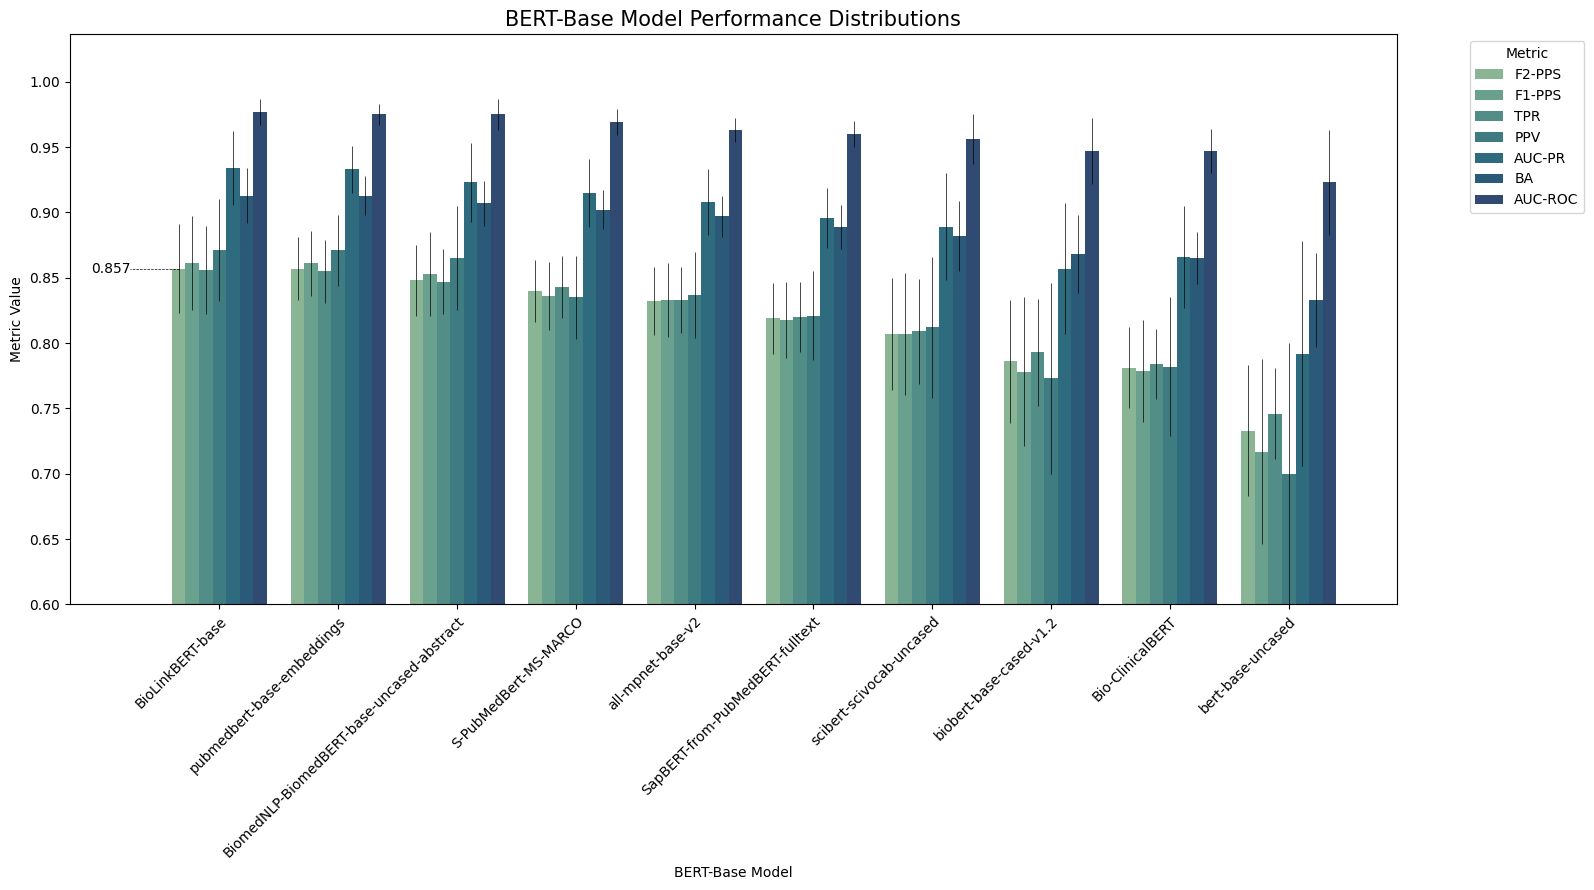

In [31]:
plot(frame, 'BERT-Base Model', output, order)

**Local** *Statistical Data Analysis* - **by T&A Link**

In [32]:
frame = get(results, 'T&A Link', order)

In [33]:
frame.to_csv(os.path.join(output, f't&a-link-ranks.csv'), encoding='utf-8', index=False)

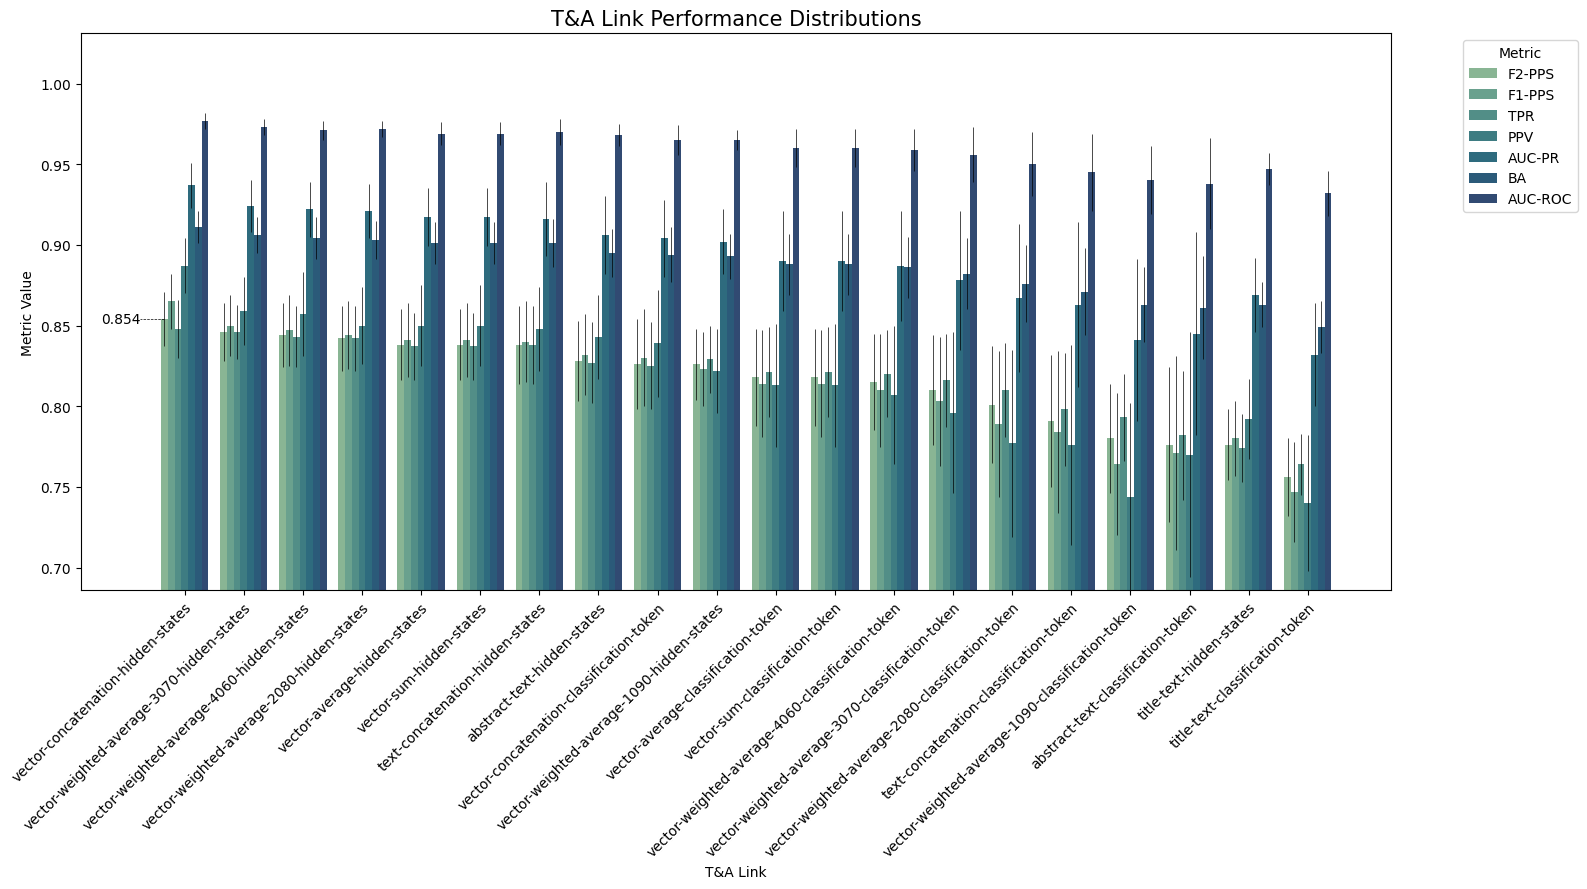

In [34]:
plot(frame, 'T&A Link', output, order)

* Select the **BERT-Base Model** with the *highest performance at the lower bound of the confidence interval*

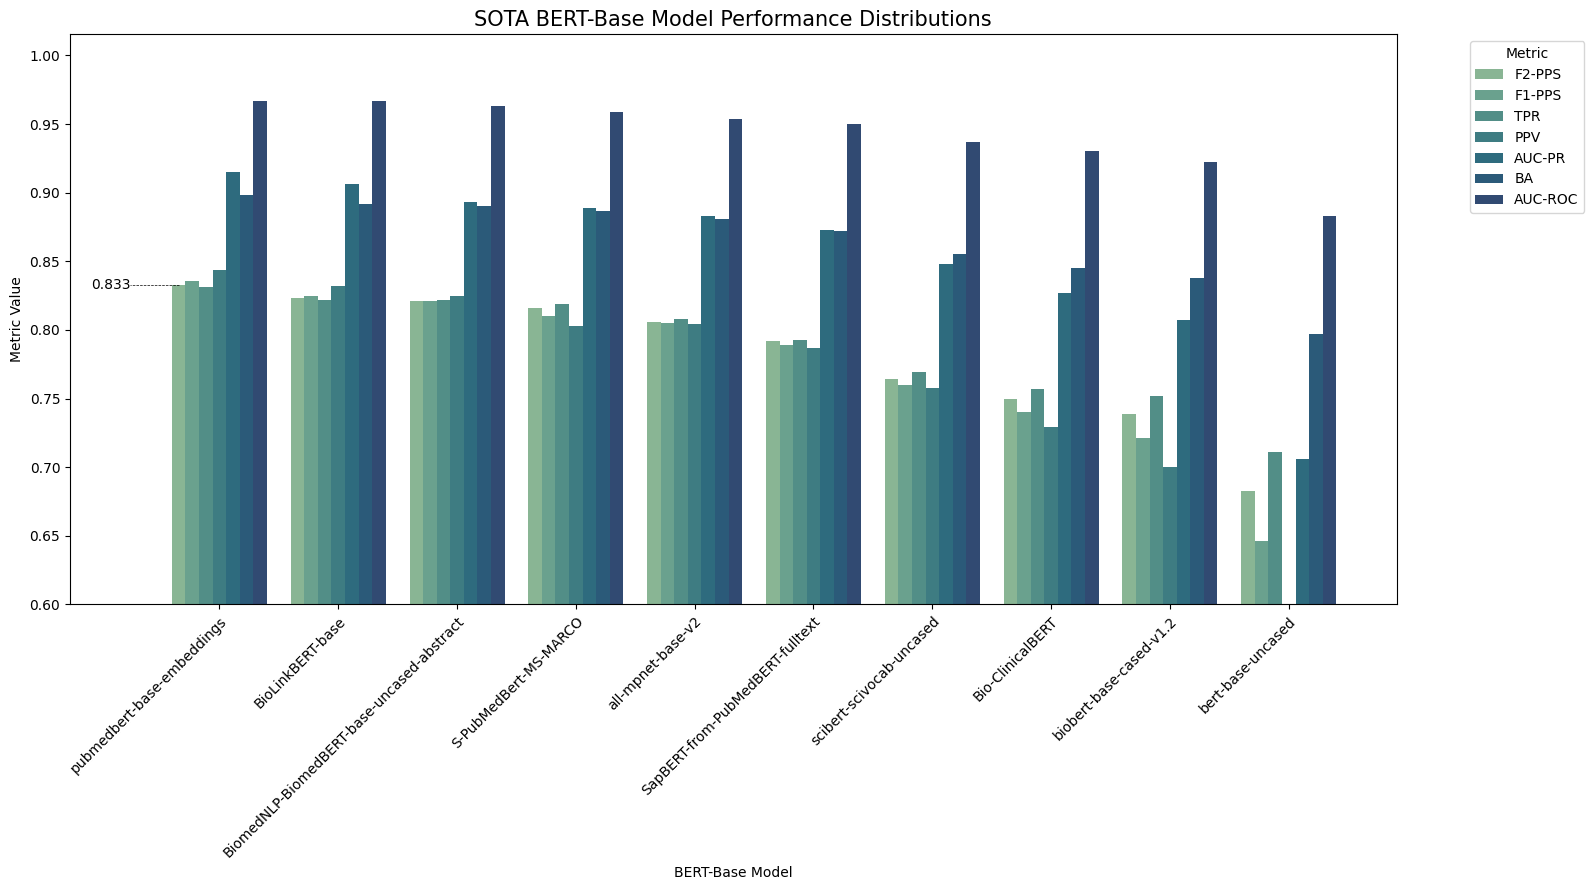

In [35]:
base = select(
    dir = os.path.join(output, f'bert-base-model-ranks.csv'),
    title = "SOTA BERT-Base Model",
    column = 'BERT-Base Model',
    output = output,
    main = ['BERT-Base Model'],
    order = order,
    model = None
)

**BiomedNLP-BiomedBERT-base-uncased-abstract**

* Select the **T&A Link** (**BiomedNLP-BiomedBERT-base-uncased-abstract**) with the *highest performance at the lower bound of the confidence interval*

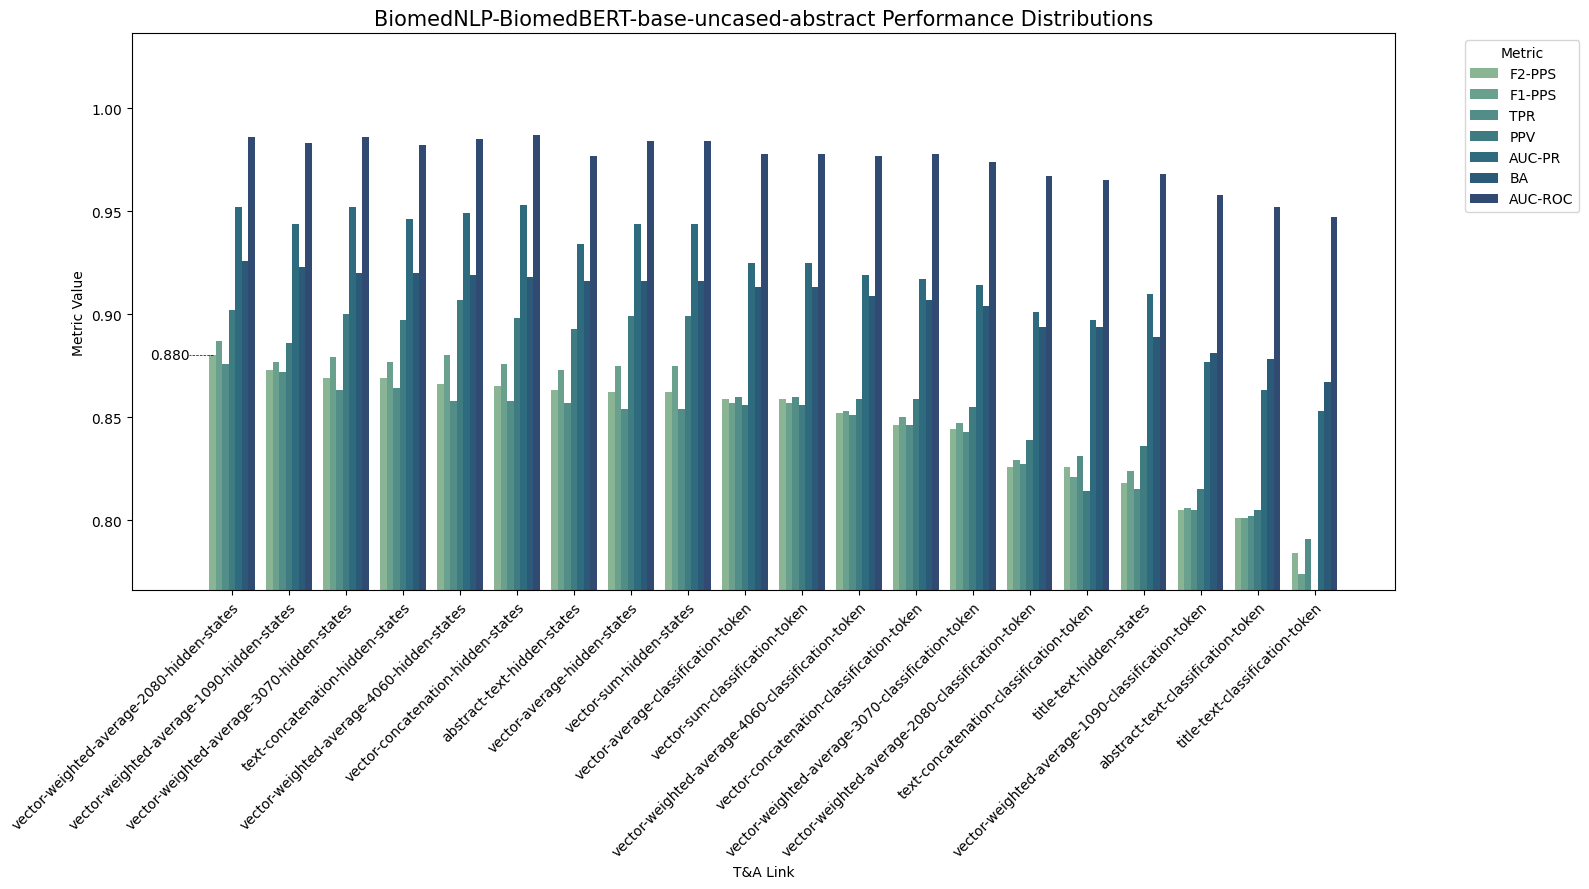

In [36]:
base = select(
    dir = os.path.join(output, f'ranks.csv'),
    title = "BiomedNLP-BiomedBERT-base-uncased-abstract",
    column = 'T&A Link',
    output = output,
    main = ['BERT-Base Model', 'T&A Link'],
    order = order,
    model = {'BERT-Base Model': 'BiomedNLP-BiomedBERT-base-uncased-abstract'}
)

**pubmedbert-base-embeddings**

* Select the **T&A Link** (**pubmedbert-base-embeddings**) with the *highest performance at the lower bound of the confidence interval*

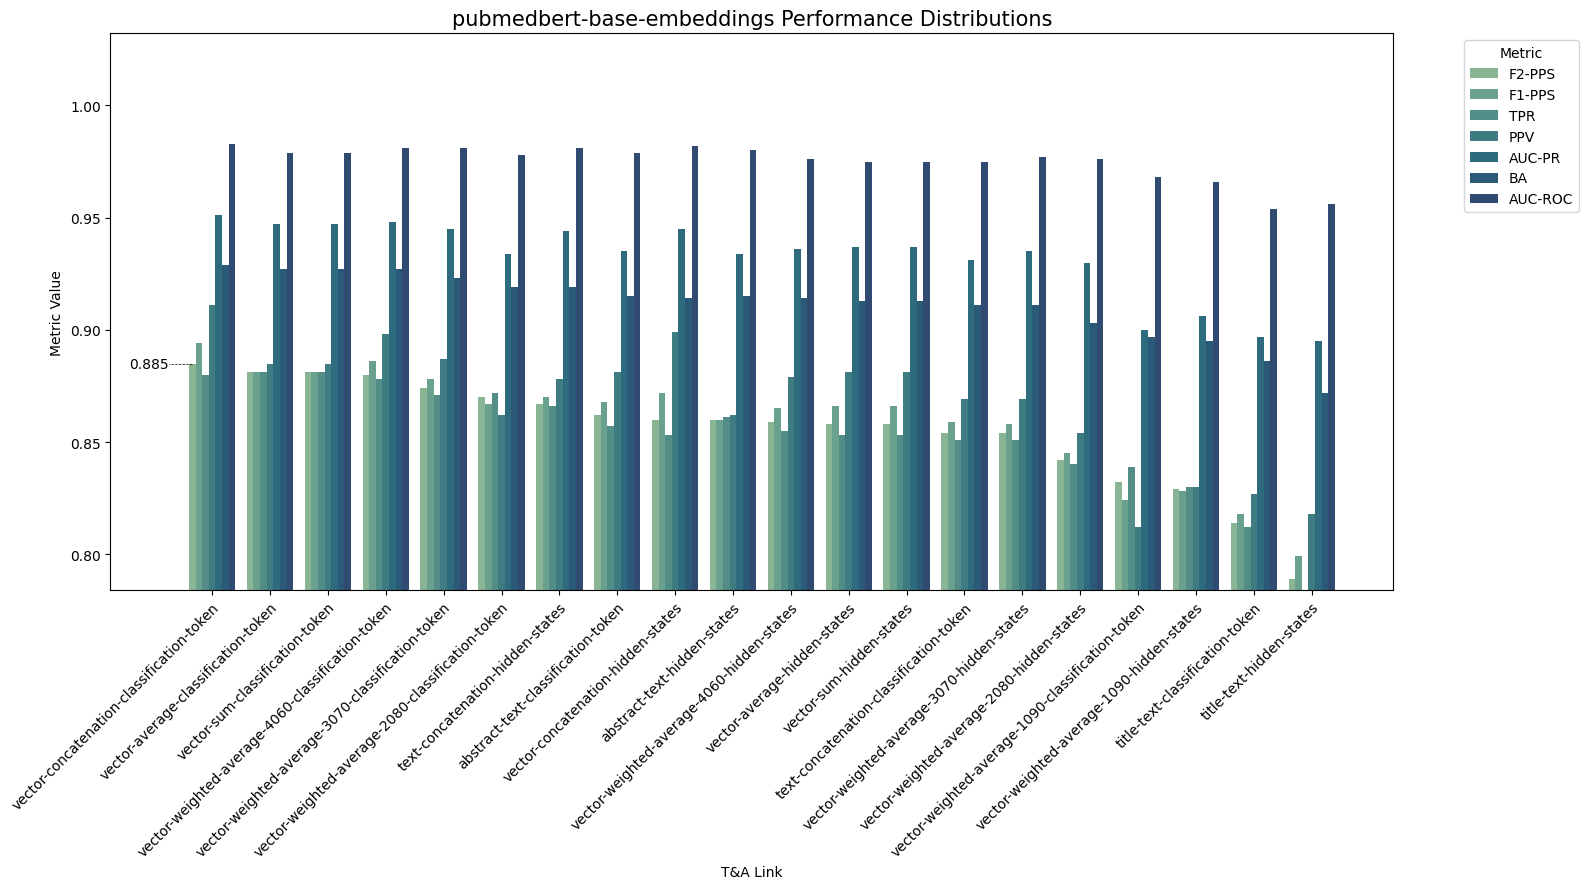

In [37]:
base = select(
    dir = os.path.join(output, f'ranks.csv'),
    title = "pubmedbert-base-embeddings",
    column = 'T&A Link',
    output = output,
    main = ['BERT-Base Model', 'T&A Link'],
    order = order,
    model = {'BERT-Base Model': 'pubmedbert-base-embeddings'}
)